# Model Evaluation

## Importing all the necessary libraries

In [21]:
import cv2
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score,classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import joblib

## Loading all the datasets

In [24]:
#loading the binary classificaion dataset
data_binary = tf.keras.preprocessing.image_dataset_from_directory(
    "Binary_Data",
    shuffle=True,
    image_size=(224,224),
    batch_size=32)

Found 8846 files belonging to 2 classes.


In [25]:
#loading the multiclass classification dataset
data_multi = tf.keras.preprocessing.image_dataset_from_directory(
    "Multiclass_Data",
    shuffle=True,
    image_size=(224,224),
    batch_size=32)

Found 8846 files belonging to 8 classes.


In [38]:
binary_class_names = data_binary.class_names
binary_class_names

['biodegradable', 'non_biodegradable']

In [39]:
multiclass_class_names = data_multi.class_names
multiclass_class_names

['ewaste',
 'food_waste',
 'leaf_waste',
 'metal_cans',
 'paper_waste',
 'plastic_bags',
 'plastic_bottles',
 'wood_waste']

## Performing train test and validation split on all the datasets

In [28]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds_binary, val_ds_binary, test_ds_binary = get_dataset_partitions_tf(data_binary)

In [29]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds_multi, val_ds_multi, test_ds_multi = get_dataset_partitions_tf(data_multi)

## Loading the models

In [30]:
binary_model = tf.keras.models.load_model('Models/binary_model.h5')

In [31]:
multiclass_model = tf.keras.models.load_model('Models/multiclass_model.h5')

## Evaluating the  models

### Classification report and ROC curve for the binary CNN model:

1/1 [==============================] - 1s 677ms/step
Classification Report:
                    precision    recall  f1-score   support

    biodegradable       0.78      0.90      0.84       452
non_biodegradable       0.89      0.76      0.82       476

         accuracy                           0.83       928
        macro avg       0.83      0.83      0.83       928
     weighted avg       0.83      0.83      0.83       928



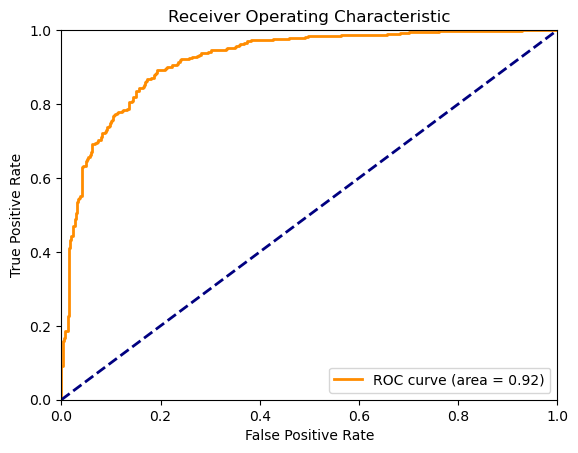

In [43]:
# Getting the true labels and predicted probabilities from the test dataset
y_true = []
y_pred = []

for images, labels in test_ds_binary:
    y_true.append(labels.numpy())
    y_pred.append(binary_model.predict(images))

# Converting lists to numpy arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Flattening in case it's a 2D array with a single column
y_pred_positive_class = y_pred.flatten()

# Converting probabilities to binary predictions (0 or 1) based on a 0.5 threshold
y_pred_class = (y_pred_positive_class >= 0.5).astype(int)

# Generating the classification report
report = classification_report(y_true, y_pred_class, target_names=binary_class_names)
print("Classification Report:\n", report)

# Plotting the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_positive_class)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


### Classification report and ROC curve for the multiclass CNN model:

In [31]:
# Getting the true labels and predicted probabilities from the test dataset
y_true = []
y_pred = []

for images, labels in test_ds_multi:
    y_true.append(labels.numpy())
    y_pred.append(multiclass_model.predict(images))

# Converting lists to numpy arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Converting predicted probabilities to predicted class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Generating the classification report
report = classification_report(y_true, y_pred_class, target_names=multiclass_class_names)
print("Classification Report:\n", report)

1/1 [==============================] - 0s 431ms/step
Classification Report:
                  precision    recall  f1-score   support

         ewaste       0.89      0.80      0.84        98
     food_waste       0.76      0.87      0.81       130
     leaf_waste       0.96      0.88      0.92       126
     metal_cans       0.68      0.82      0.75       107
    paper_waste       0.70      0.75      0.72       118
   plastic_bags       0.90      0.78      0.83       120
plastic_bottles       0.84      0.76      0.80       110
     wood_waste       0.84      0.82      0.83       119

       accuracy                           0.81       928
      macro avg       0.82      0.81      0.81       928
   weighted avg       0.82      0.81      0.81       928



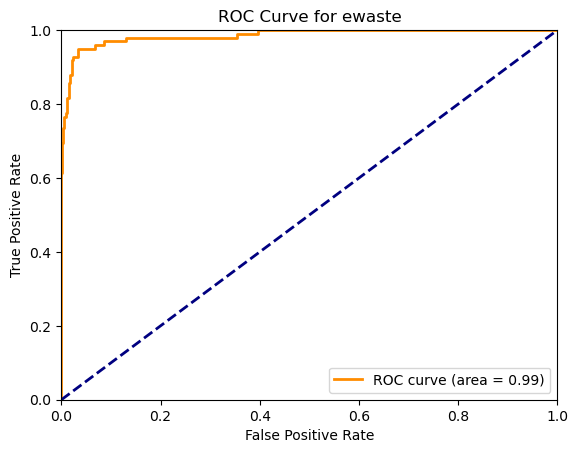

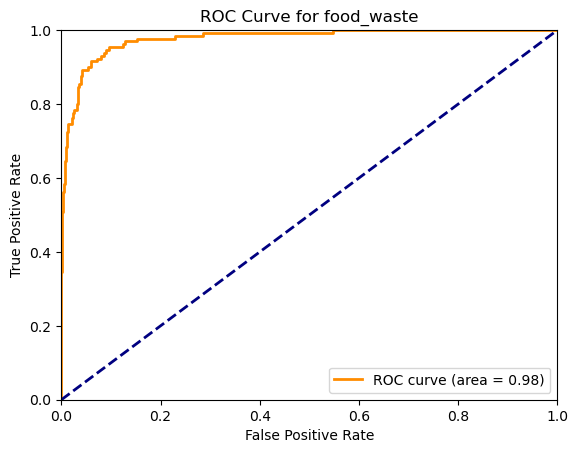

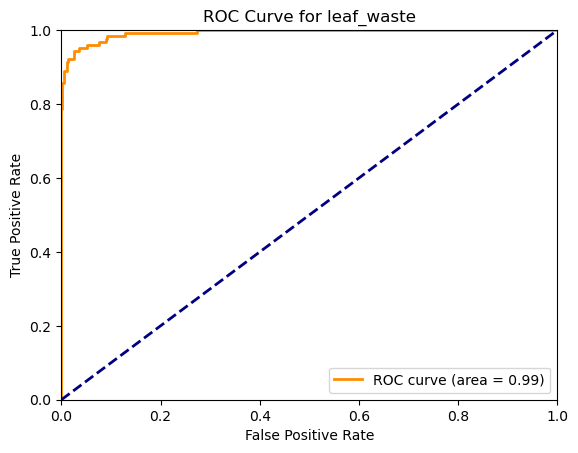

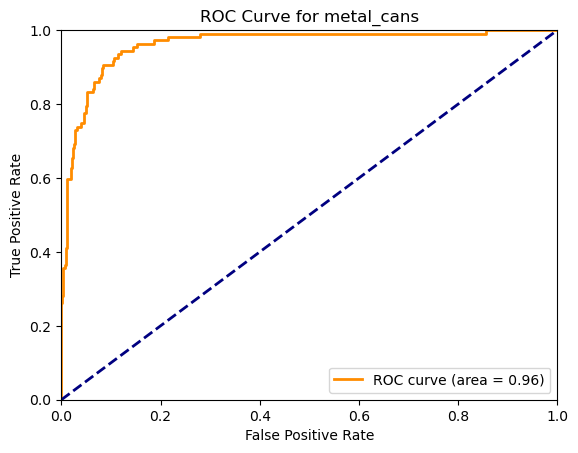

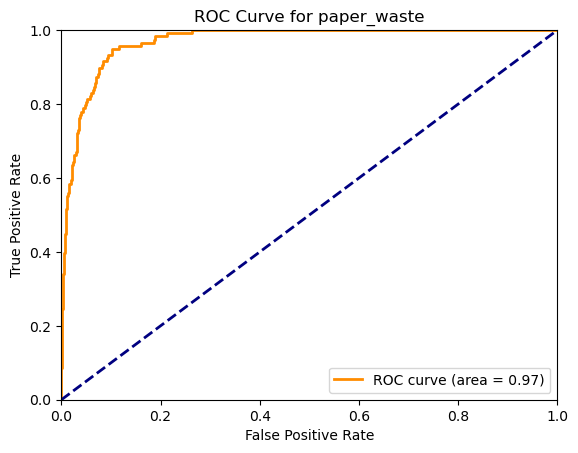

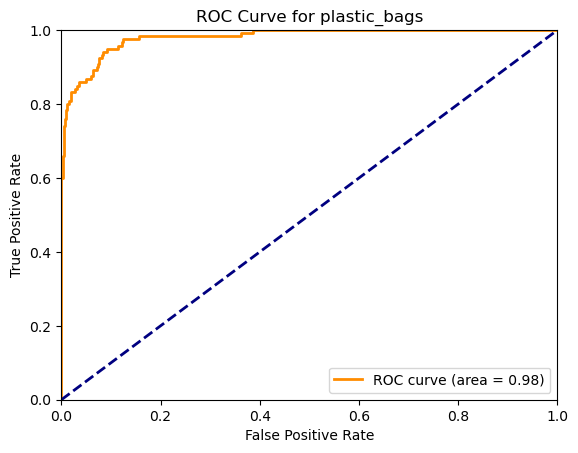

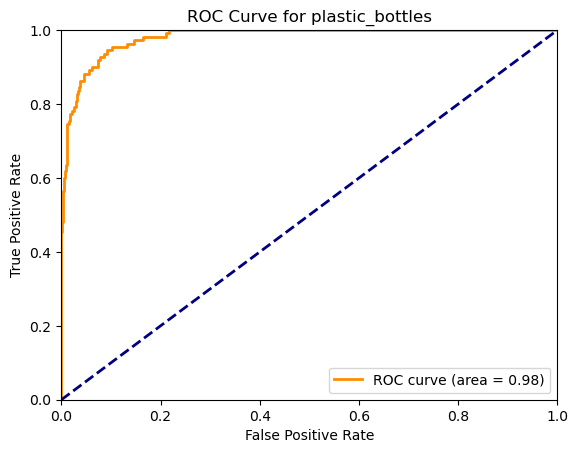

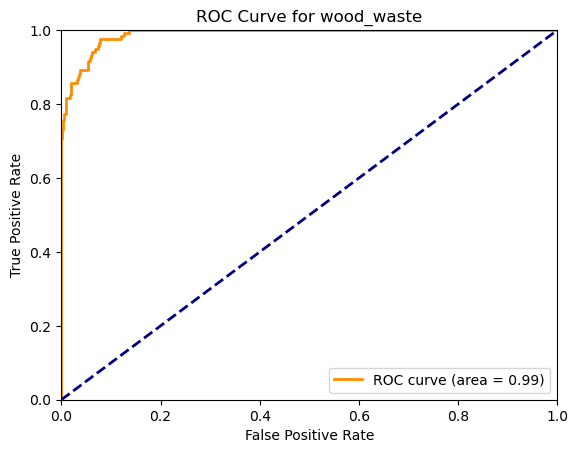

In [32]:
n_classes = len(multiclass_class_names)

# Binarizing the true labels for each class
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Computing ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve for each class individually using custom class names
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {multiclass_class_names[i]}')
    plt.legend(loc='lower right')
    plt.show()